In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b3

from sklearn.metrics import classification_report, accuracy_score

# created library
import dataaugmentation
import mydata
from skindetection import SkinExtraction
from skincolors import IndividualTypologyAngle
from performance import PerformanceMeasure, PerformanceEstimation


from mymodels import TransDataset, EfficientB3Model
import training

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
2024-08-13 15:49:39.014389: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 15:49:39.037958: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 15:49:39.657278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# to reproduce

seed = 42
random.seed(seed) #　ほかのモジュールで使われているかも
np.random.seed(seed) # ほかのモジュールで使われているかも
torch.manual_seed(seed) # Pytorchの中のシード
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True # GPUの計算過程の変化をさせない

In [3]:
db = "HAM"
root = f"../../dataset/AAAI 2025/{db}/"
df_train = mydata.load_and_process_csv(f"{root}/dataframe/df_train.csv")
df_valid = mydata.load_and_process_csv(f"{root}/dataframe/df_valid.csv")
df_test = mydata.load_and_process_csv(f"{root}/dataframe/df_test_with_skincolor.csv")

In [4]:
ycol="labels"
batch_size = 8
train_loader, valid_loader, test_loader = training.create_dataloaders(df_train, df_valid, df_test, ycol, batch_size)

H*W:  (450, 600)


Validation Accuracy: 0.6000 | Loss: 0.6747 | F1: 0.6998
Validation Accuracy: 0.6785 | Loss: 0.6530 | F1: 0.7473
Validation Accuracy: 0.7108 | Loss: 0.6238 | F1: 0.7707
Validation Accuracy: 0.7615 | Loss: 0.5828 | F1: 0.8010
Validation Accuracy: 0.7462 | Loss: 0.5570 | F1: 0.7898
Validation Accuracy: 0.7800 | Loss: 0.5150 | F1: 0.8086
Validation Accuracy: 0.7831 | Loss: 0.4862 | F1: 0.8102
Validation Accuracy: 0.7862 | Loss: 0.4649 | F1: 0.8119
Validation Accuracy: 0.7908 | Loss: 0.4457 | F1: 0.8101
Validation Accuracy: 0.7969 | Loss: 0.4381 | F1: 0.8024
Validation Accuracy: 0.7923 | Loss: 0.4372 | F1: 0.8178
Validation Accuracy: 0.8031 | Loss: 0.4277 | F1: 0.8123
Validation Accuracy: 0.7908 | Loss: 0.4191 | F1: 0.7908
Validation Accuracy: 0.7846 | Loss: 0.4311 | F1: 0.7690
Validation Accuracy: 0.8046 | Loss: 0.4113 | F1: 0.8073
Validation Accuracy: 0.8077 | Loss: 0.4059 | F1: 0.8019
Validation Accuracy: 0.8000 | Loss: 0.4006 | F1: 0.7937
Validation Accuracy: 0.8231 | Loss: 0.3873 | F1:

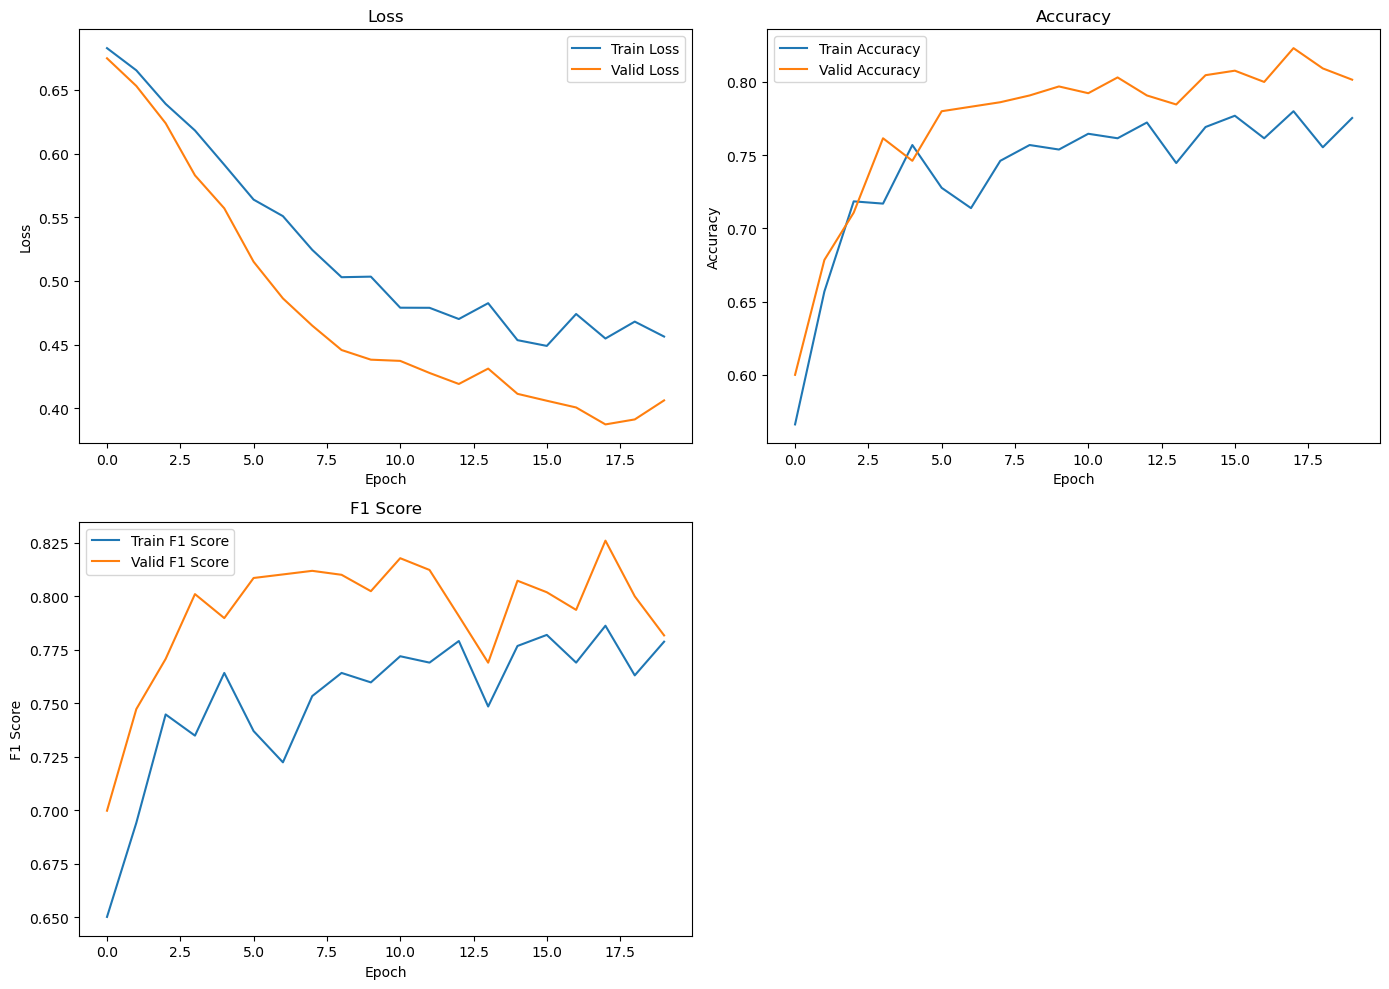

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_save_directory = f"{root}/model/efficientnet/"
model = EfficientB3Model().to(device) # model -> GPU

# Train the model
num_epochs = 20
lr = 0.00001
best_val_file = training.train_model(model, train_loader, valid_loader, model_save_directory, num_epochs=num_epochs, lr=lr)

## Evaluation

In [6]:
model = EfficientB3Model().to(device) # model -> GPU
model.load_state_dict(torch.load(best_val_file))

model.eval() # 評価モードに入る。dropoutは学習にしか使わない。dropoutはノイズを入れている。ノイズに耐えられるように。
with torch.no_grad():
    test_predictions = []
    test_outputs = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) # data -> GPU
        outputs = model(inputs)
        # _, test_predictions = torch.max(outputs, 1) # outputsの大きい方が選ばれるけど、二値分類なので異なる
        test_outputs.append(outputs)
        test_predictions.extend(1 if x >= 0 else 0 for x in outputs) # Appendは１つ、extendは複数

df_test["predictions"] = test_predictions

In [7]:
training.test_classification_report(df_test)
df_test.to_csv(f"../../dataset/AAAI 2025/{db}/evaluation/df_test_ef3.csv", index=False)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       434
           1       0.81      0.83      0.82       434

    accuracy                           0.82       868
   macro avg       0.82      0.82      0.82       868
weighted avg       0.82      0.82      0.82       868

Skin tone 1: Accuracy 0.8202764976958525
